# Welcome to Jupyter!

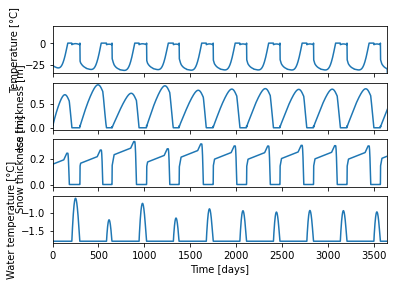

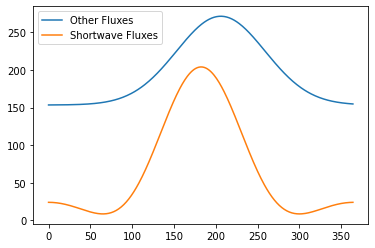

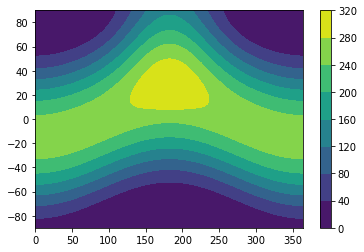

In [2]:

##########################################################################
# This program implements a more advanced version of the zero-layer model.
# It carries out the following steps:
# 1. Calculate surface temperature T_surf from heat-flux balance
# 2. If T_surf > 273 K, set T_surf to 273 K and calculate surface melting
# 3. Calculate heat flux in ice assuming a linear temperature profile
# 4. Calculate change in ice thickness from energy balance and ice bottom
# 5. Calculate new ice thickness
#
# Based on AGF 211 exercise, part 3.1
#
# Written by Dirk Notz
#
# 07 February 2013
#
#########################################################################

import numpy as np
import matplotlib.pyplot as plt



def snowfall(day):
    if day>232 and day <=304:       
        SF = 0.30/72
    elif day > 304 or day < 122:
        SF = 0.05/176
    elif day >=122 and day < 154:
        SF = 0.05/31
    else:
        SF = 0
    #SF=0
    return SF 

def otherfluxes(day):
    LW = 118. * np.exp(-0.5 * (day-206.)**2 / (53.**2)) + 145.#179.
    return LW+8.5
  
#def shortwave(day):
#    SW  = 314 * np.exp(-(day-164.)**2/4608.)
#    return SW

def shortwave(day, lat=90.):
    swAA=np.sin(day/365*np.pi)**6*np.sin(lat/180.*np.pi)
    if lat<0: swAA=0.
    sw=np.cos((lat-30.*np.sin(day/365*np.pi)**2+15.)/360.*2*np.pi)**2 +0.5* swAA
    sw=sw*360.
    return sw
    

def albedo(day):
    alpha=-0.431/(1+((day-207.)/44.5)**2)+0.914
    return alpha

Q_ocean   = 13.5                # Heat flux from the water
albedow   = 0.1               # albedo of the water
h_ice1    = 0.               # Initial ice thickness
eps_sigma = 0.95*5.67e-8      # Constant in Boltzman-law
L         = 334000.           # Latent heat of freezing for water [J/kg]
c_w       = 4000.             # Heat capacity of water
depth     = 50.               # Depth of the mixed layer
rho_w     = 1025.             # Density of sea water
rho_i     = 970.              # density of ice [kg/m^3]
rho_s     = 330.              # density of snow [kg/m^3]
k_ice     = 2.2               # heat conductivity of ice [W/(m K)]
k_snow    = 0.3               # heat conductivity of snow [W/(m K)]
Tbot      = -1.8+273.15       # Bottom temperature in Kelvin
dt        = 86400.
days=3650


T_water=np.zeros(days+1)+Tbot
h_snow=np.zeros(days+1)
h_ice=np.zeros(days+1)
h_ice[0]=h_ice1
Tsurf=np.zeros(days+1)


for day in range(days):
    doy=day%365
    if doy==0: doy=365
    
    if h_ice[day] > 0:
        Q_surf_in = (1-albedo(doy))*shortwave(doy) + otherfluxes(doy)
        
        # Calculate surface temperature
        a = eps_sigma
        b = 0.
        c = 0.
        d = 1./(h_ice[day]/k_ice+h_snow[day]/k_snow)
        e = - Q_surf_in  - Tbot/(h_ice[day]/k_ice+h_snow[day]/k_snow)
        Tsurf[day]= np.max(np.real(np.roots([a,b,c,d,e])))
        
        if Tsurf[day] > 273.15: 
            Tsurf[day]   = 273.15
        
        # Heat flux in the ice
        Q_ice       = - (Tsurf[day] - Tbot) / (h_ice[day]/k_ice + h_snow[day]/k_snow)
        
        # Outgoing longwave heat flux
        Q_surf_out  = eps_sigma * Tsurf[day]**4
        
        # Calculate heat flux imbalance at surface. 
        # This is zero as long as Tsurf < 273.15
        Q_surf      = Q_surf_out - Q_surf_in - Q_ice
        
        # Calculate thickness change at bottom
        delta_h_bot = (Q_ice-Q_ocean) * dt /  (rho_i * L)          
        
        # Calculate thickness change at surface
        if h_snow[day] > 0:
          delta_h_snow = Q_surf *dt /  (rho_s * L)
          delta_h_surf = 0
        else:
          delta_h_surf = Q_surf *dt /  (rho_i * L)                    
          delta_h_snow = 0
        
        # Calculate new ice thickness
        h_ice[day+1]     = h_ice[day] + delta_h_surf + delta_h_bot           
        
        # Calculate new snow thickness
        h_snow[day+1] = h_snow[day] + snowfall(doy) + delta_h_snow

        # If more snow melted than we had, melt some ice
        if h_snow[day+1] < 0:
            h_ice[day+1]=h_ice[day+1]+h_snow[day+1]*rho_s/rho_i
            h_snow[day+1] = 0
        
        T_water[day+1]=Tbot

    else:   # If there is no more ice
       
        # Set surface temperature to water temperature
        Tsurf[day] = T_water[day]  
    
        # Calculate heat flux at sea surface
        Q_surf = -((1 - albedow) * shortwave(doy) + otherfluxes(doy)) + eps_sigma * T_water[day]**4
    
        # Change water temperature accordingly
        T_water[day+1] = T_water[day] - Q_surf / (rho_w*c_w * depth) * dt
    
        # Change water temperatute for the few cases where h_ice <0, otherwise
        # nothing happens here since h_ice is usually 0
        T_water[day+1] = T_water[day+1] - h_ice[day] * rho_i * L / (rho_w * c_w * depth)
    
        # Set h_ice to 0
        h_ice[day] = 0
    
        # If water starts freezing, set temperature to freezing temperature
        # and use excess heat to form some ice
        if T_water[day+1] < Tbot:
            h_ice[day+1] = -(T_water[day+1] - Tbot) * rho_w * c_w * depth / (rho_i * L)
            T_water[day+1] = Tbot
            h_snow[day+1] = 0
        else:
            h_ice[day+1] = 0
            h_snow[day+1] = 0

if 1:
  # Plot temperature evolution
  fig, axes=plt.subplots(nrows=4, sharex=True)
  ax=axes[0]
  ax.plot(Tsurf-273.15)
  ax.set_xlim([0, days])
  ax.set_ylim([-35,20])
  #ax.set_xlabel('day')
  ax.set_ylabel('Temperature [°C]')

  # Plot ice-thickness evolution
  ax=axes[1]
  ax.plot(h_ice)
  ax.set_xlim([0, days])
  #ax.set_xlabel('day')
  ax.set_ylabel('Ice thickness [m]')
  
  # Plot snow-thickness evolution
  ax=axes[2]
  ax.plot(h_snow)
  ax.set_xlim([0, days])
  #ax.set_xlabel('day')
  ax.set_ylabel('Snow thickness [m]')
  
  # Plot water temperature
  ax=axes[3]
  ax.plot(T_water-273.15)
  ax.set_xlim([0, days])
  ax.set_xlabel('Time [days]')
  ax.set_ylabel('Water temperature [°C]')
  
if 1:#plot seasonal cycle
    fig, ax=plt.subplots()
    doys=np.arange(365)
    otherf=np.zeros(365)
    swf=np.zeros(365)
    for doy in doys:
        otherf[doy]=otherfluxes(doy)
        swf[doy]=shortwave(doy)
    ax.plot(doys, otherf, label='Other Fluxes')
    ax.plot(doys, swf, label='Shortwave Fluxes')
    plt.legend()
    
    
if 1:#find approximation of fig 3a in https://acp.copernicus.org/articles/5/2847/2005/acp-5-2847-2005.pdf
    #plt.figure()
    lats=np.linspace(-90,90, 100)
    doys=np.arange(365)
    lats2d, doys2d=np.meshgrid(lats, doys)

    swAA=np.sin(doys2d/365*np.pi)**6*np.sin(lats2d/180.*np.pi)
    swAA[lats2d<0]=0.
    sw=np.cos((lats2d-30.*np.sin(doys2d/365*np.pi)**2+15.)/360.*2*np.pi)**2 +0.5* swAA
    sw=sw*265.
    
    plt.figure()
    plt.contourf(doys2d,lats2d, sw)
    plt.colorbar()
    

This repo contains an introduction to [Jupyter](https://jupyter.org) and [IPython](https://ipython.org).

Outline of some basics:

* [Notebook Basics](../examples/Notebook/Notebook%20Basics.ipynb)
* [IPython - beyond plain python](../examples/IPython%20Kernel/Beyond%20Plain%20Python.ipynb)
* [Markdown Cells](../examples/Notebook/Working%20With%20Markdown%20Cells.ipynb)
* [Rich Display System](../examples/IPython%20Kernel/Rich%20Output.ipynb)
* [Custom Display logic](../examples/IPython%20Kernel/Custom%20Display%20Logic.ipynb)
* [Running a Secure Public Notebook Server](../examples/Notebook/Running%20the%20Notebook%20Server.ipynb#Securing-the-notebook-server)
* [How Jupyter works](../examples/Notebook/Multiple%20Languages%2C%20Frontends.ipynb) to run code in different languages.

You can also get this tutorial and run it on your laptop:

    git clone https://github.com/ipython/ipython-in-depth

Install IPython and Jupyter:

with [conda](https://www.anaconda.com/download):

    conda install ipython jupyter

with pip:

    # first, always upgrade pip!
    pip install --upgrade pip
    pip install --upgrade ipython jupyter

Start the notebook in the tutorial directory:

    cd ipython-in-depth
    jupyter notebook